In [ ]:
# !pip install --upgrade tensorflow
import tensorflow
print(tensorflow.__version__)
# import tensorflow as tf
# tf.__version__

2.10.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
train = zipfile.ZipFile("/content/drive/MyDrive/ai cup/crop_224_train.zip")
train.extractall("datas")
test = zipfile.ZipFile("/content/drive/MyDrive/ai cup/crop_224_validation.zip")
test.extractall("datas")

In [ ]:
import os
import random
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model

In [ ]:
train_dir = 'datas/crop_224_train'
d = {folder:idx for idx, folder in enumerate(os.listdir(train_dir))}
classes = list(d)

img_files = []
labels = []
for folder in os.listdir(train_dir):
    for img_file in os.listdir(os.path.join(train_dir, folder)):
        img_files.append(os.path.join(train_dir, folder, img_file))
        labels.append(folder)

df_train = pd.DataFrame({
    'path': img_files,
    'ans': labels
})

df_train["ans"] = df_train["ans"].replace(d) 
df_train

,path,ans
0,datas/crop_224_train/betel/b41d4f29-3c78-4b74-...,0
1,datas/crop_224_train/betel/6624282a-d06a-4775-...,0
2,datas/crop_224_train/betel/7358cc9c-c0ee-4038-...,0
3,datas/crop_224_train/betel/418eea1f-79ad-40b2-...,0
4,datas/crop_224_train/betel/a2d0809a-2c81-4f18-...,0
...,...,...
40907,datas/crop_224_train/tea/10af2dce-6f55-4e4e-b6...,32
40908,datas/crop_224_train/tea/746d1193-b15e-43a8-a7...,32
40909,datas/crop_224_train/tea/deb9257c-2bc6-44be-8b...,32
40910,datas/crop_224_train/tea/70fd7c52-006e-44bf-81...,32


In [ ]:
test_dir = 'datas/crop_224_validation'

img_files = []
labels = []
for folder in os.listdir(test_dir):
    for img_file in os.listdir(os.path.join(test_dir, folder)):
        img_files.append(os.path.join(test_dir, folder, img_file))
        labels.append(folder)

df_test = pd.DataFrame({
    'path': img_files,
    'ans': labels
})

df_test["ans"] = df_test["ans"].replace(d) 
df_test

,path,ans
0,datas/crop_224_validation/betel/67f48ba8-3cb6-...,0
1,datas/crop_224_validation/betel/df527392-27f1-...,0
2,datas/crop_224_validation/betel/e7b929ad-3ee1-...,0
3,datas/crop_224_validation/betel/9ea4be7e-dacd-...,0
4,datas/crop_224_validation/betel/a14d8535-7d87-...,0
...,...,...
3295,datas/crop_224_validation/tea/6d3a600b-d6cc-4e...,32
3296,datas/crop_224_validation/tea/19a44ae2-e858-44...,32
3297,datas/crop_224_validation/tea/c9db872c-b04e-48...,32
3298,datas/crop_224_validation/tea/e363c0c5-186a-40...,32


In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16
# cnn = VGG16(include_top=False, input_shape=(224, 224, 3))

# for layer in cnn.layers:
#     layer.trainable = False

# mlp = [
#     # 512 * 4 = 2048(一半不訓練[原本平均. 標準差], 一半訓練[後來平均, 後來標準差])
#     BatchNormalization(),
#     Flatten(),
#     Dense(256, activation="relu"),
#     Dropout(0.25),
#     Dense(33, activation="softmax")
# ]
# model = Sequential(cnn.layers + mlp)
# model.summary()

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
# resnet_model = ResNet50(input_shape=(224,224,3),
#                        weights='imagenet',
#                        pooling='avg',
#                        include_top=False)

# for layer in resnet_model.layers:
#     layer.trainable = False

# x = resnet_model.output
# x = BatchNormalization()(x)
# x = Flatten()(x)
# x = Dense(2048, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.25)(x)
# output = Dense(33, activation='softmax')(x)
# model = Model(inputs = resnet_model.input, outputs = output)

# model.summary()

In [ ]:
from tensorflow.keras.applications import EfficientNetV2L
efficient_model = EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3))

for layer in efficient_model.layers:
    layer.trainable = False
 
x = efficient_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(33, activation='softmax')(x)
model = Model(inputs = efficient_model.input, outputs = output)

model.summary()

473176280/473176280 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['rescaling[0][0]']              
                                )                                                                 
                           

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy   # SigmoidFocalCrossEntropy
model.compile(loss=CategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

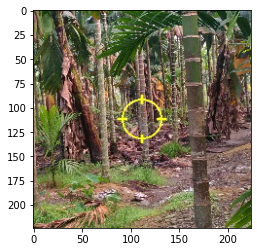

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
img = load_img(df_train["path"][0], target_size=(224, 224))
plt.imshow(img)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
x_train = np.array(df_train["path"])
y_train = np.array(df_train["ans"])
y_train = to_categorical(y_train, num_classes=33)

x_test = np.array(df_test["path"])
y_test = np.array(df_test["ans"])
y_test = to_categorical(y_test, num_classes=33)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(40912,)
(40912, 33)
(3300,)
(3300, 33)


In [ ]:
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
def get_data(x, y, batch=128):
    idx = np.random.randint(0, len(x), batch)
    x_idx, y_idx = x[idx], y[idx]
    x_ori, x_norm, y_ori = [], [], y_idx
    for p in x_idx:
        img = np.array(load_img(p, target_size=(224, 224)))
        img_pre = preprocess_input(img)
        x_ori.append(img)
        x_norm.append(img_pre)
    return np.array(x_ori), np.array(x_norm), np.array(y_ori)

In [ ]:
history_train_loss = []
history_train_accuracy = []
history_val_loss = []
history_val_accuracy = []
epochs = 1000

for i in range(epochs):
    print("[times]:", i)
    _, x_train_batch, y_train_batch = get_data(x_train, y_train)
    history_train = model.train_on_batch(x_train_batch, y_train_batch)
    train_loss = history_train[0]
    train_accuracy = history_train[1]
    history_train_loss.append(train_loss)
    history_train_accuracy.append(train_accuracy)
    print("[Train]:", history_train)
    
    _, x_test_batch, y_test_batch = get_data(x_test, y_test)
    history_test = model.test_on_batch(x_test_batch, y_test_batch)
    val_loss = history_test[0]
    val_accuracy = history_test[1]
    history_val_loss.append(val_loss)
    history_val_accuracy.append(val_accuracy)
    print("[Test]:", history_test)

[times]: 0
[Train]: [3.5007240772247314, 0.0234375]
[Test]: [3.4589662551879883, 0.046875]
[times]: 1
[Train]: [3.3513355255126953, 0.078125]
[Test]: [3.477509021759033, 0.109375]
[times]: 2
[Train]: [3.222611427307129, 0.125]
[Test]: [3.3888254165649414, 0.140625]
[times]: 3
[Train]: [3.1387314796447754, 0.1875]
[Test]: [3.0423426628112793, 0.28125]
[times]: 4
[Train]: [2.9180920124053955, 0.25]
[Test]: [3.2077670097351074, 0.125]
[times]: 5
[Train]: [3.1187992095947266, 0.1953125]
[Test]: [2.7627785205841064, 0.234375]
[times]: 6
[Train]: [2.8129961490631104, 0.25]
[Test]: [2.7956418991088867, 0.1640625]
[times]: 7
[Train]: [2.520775079727173, 0.328125]
[Test]: [3.0551657676696777, 0.1328125]
[times]: 8
[Train]: [2.6835708618164062, 0.25]
[Test]: [2.725821018218994, 0.2734375]
[times]: 9
[Train]: [2.4688658714294434, 0.2734375]
[Test]: [2.2916038036346436, 0.34375]
[times]: 10
[Train]: [2.229668378829956, 0.34375]
[Test]: [2.6481823921203613, 0.2109375]
[times]: 11
[Train]: [2.370620

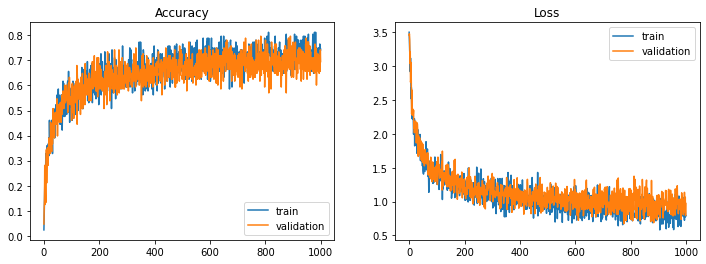

In [ ]:
# 顯示訓練結果
epochs_range = range(len(history_train_loss))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, history_train_accuracy, label='train')
plt.plot(epochs_range, history_val_accuracy, label='validation')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_train_loss, label='train')
plt.plot(epochs_range, history_val_loss, label='validation')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/model.h5')
# model = load_model('/content/drive/MyDrive/model.h5')

In [ ]:
x_ori, x_batch, y_batch = get_data(x_test, y_test, 3000)
model.evaluate(x_batch, y_batch)

94/94 [==============================] - 12s 62ms/step - loss: 0.9475 - accuracy: 0.7113


[0.9474948048591614, 0.7113333344459534]

94/94 [==============================] - 11s 54ms/step


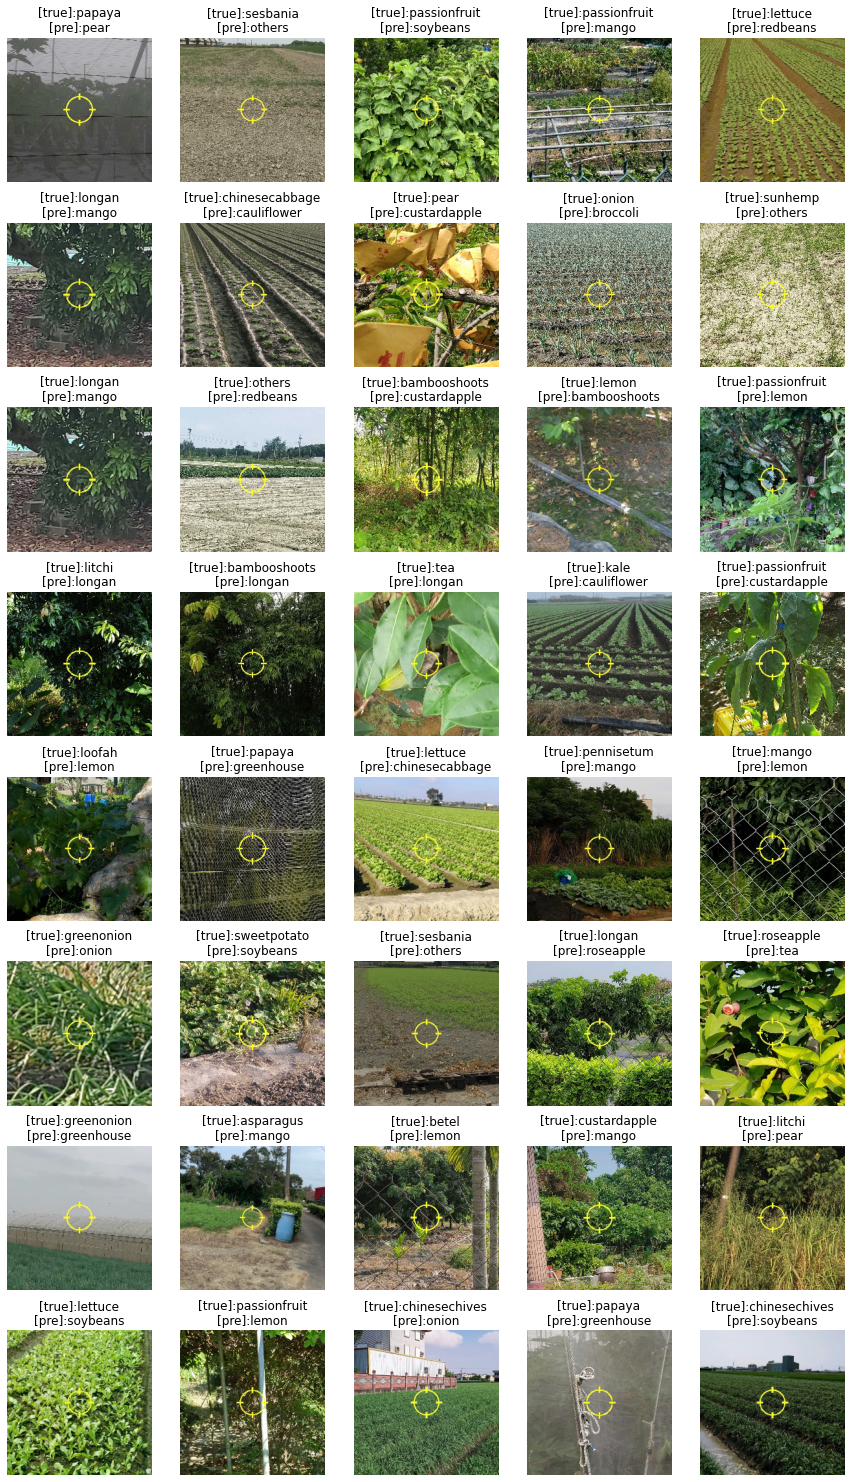

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 30))
pre = model.predict(x_batch).argmax(axis=-1)
true = y_batch.argmax(axis=-1)
idxs = np.nonzero(pre != true)[0]
# idxs = idxs[:40]
idxs = random.sample(set(idxs), 40)
width = 5
height = len(idxs) // width + 1
for i, idx in enumerate(idxs):
    img, label, p = x_ori[idx], true[idx], pre[idx]
    title = "[true]:{}\n[pre]:{}".format(classes[label], classes[p])
    plt.subplot(height, width, i+1)
    plt.title(title)
    plt.axis("off")
    plt.imshow(img)

In [ ]:
from sklearn.metrics import precision_score, f1_score

precision_score = precision_score(true, pre, average='weighted')
f1_score = f1_score(true, pre, average=None)
print('precision_score:', precision_score)
pd.DataFrame(f1_score, index=classes, columns=['f1_score']).sort_values(by='f1_score', ascending=False)

precision_score: 0.748391738150651


,f1_score
waterbamboo,0.944162
pennisetum,0.919786
taro,0.911628
asparagus,0.860465
bambooshoots,0.838384
chinesechives,0.825175
tea,0.804734
broccoli,0.795455
lettuce,0.763006
kale,0.762590


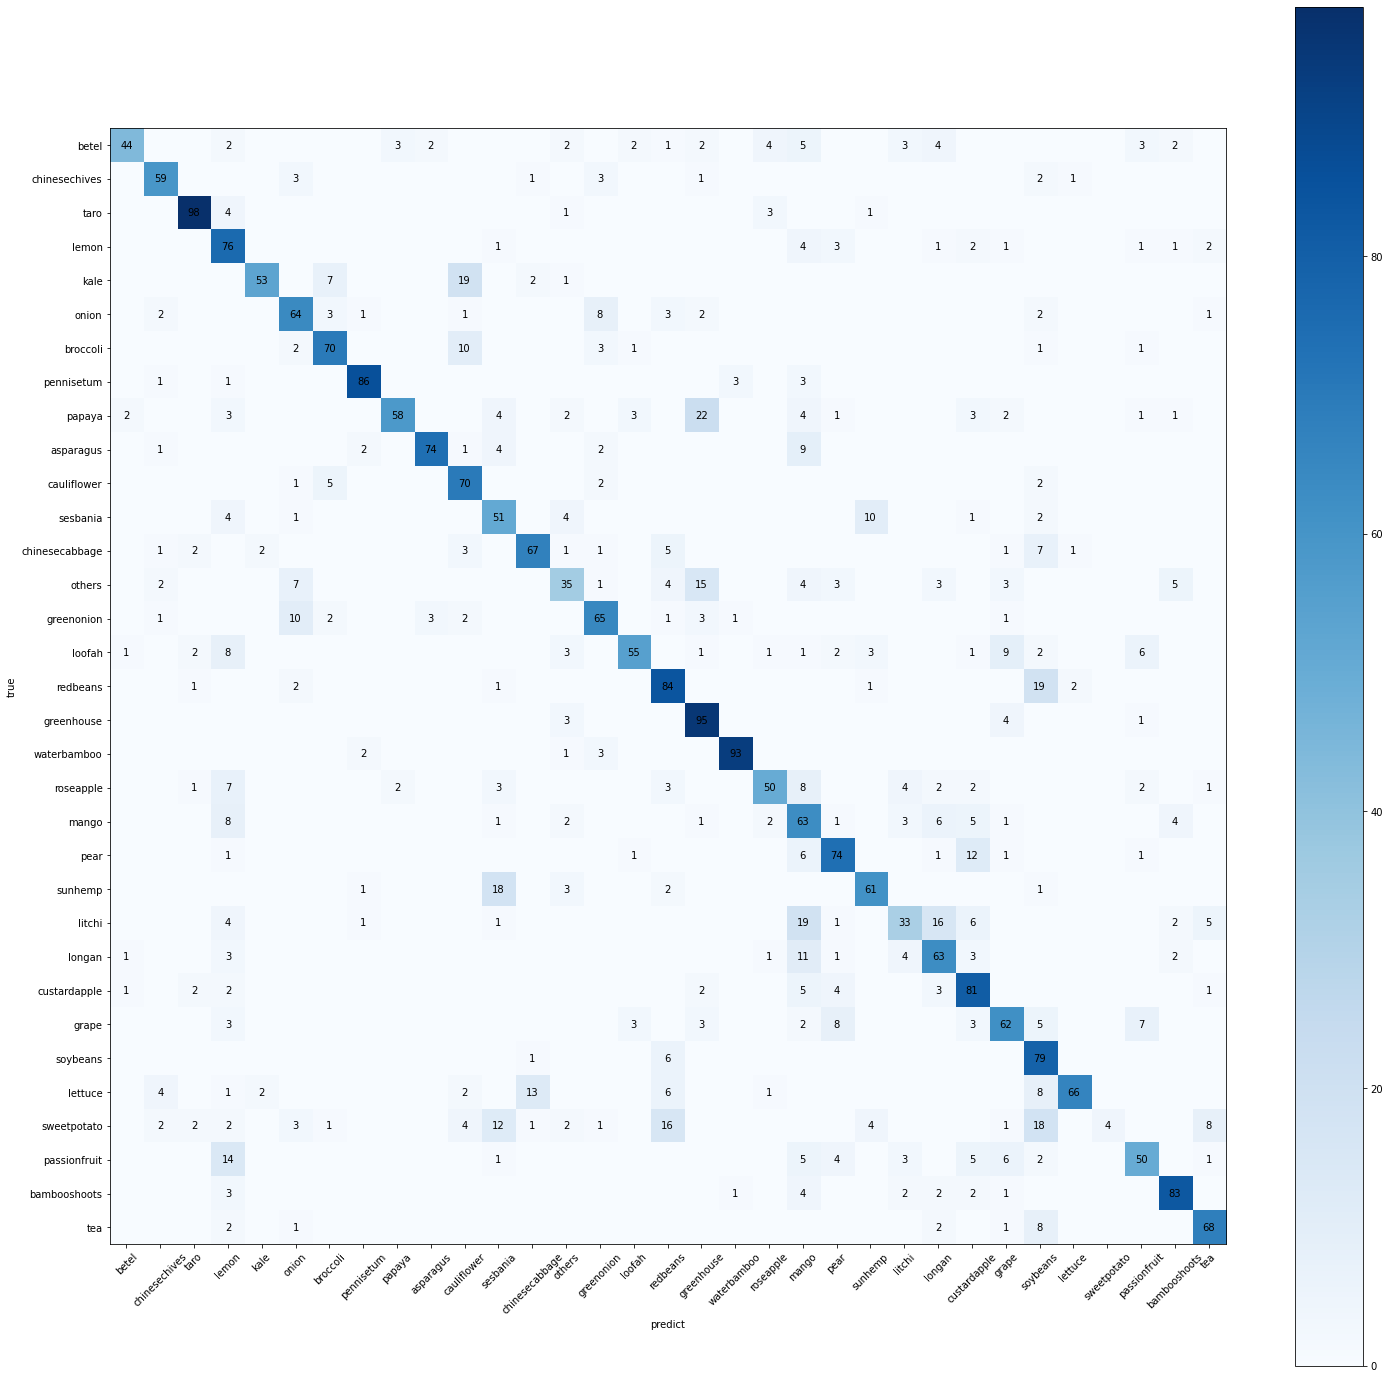

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, pre)
plt.figure(figsize=(25,25))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('predict')
plt.ylabel('true')
plt.xticks(range(len(cm)), classes, rotation=45)
plt.yticks(range(len(cm)), classes)

for i in range(len(cm)):
    for j in range(len(cm)):
        if cm[i][j] > 0:
            plt.text(x=j, y=i, s=cm[i][j], va='center', ha='center')